In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import brentq, curve_fit
from scipy.misc import derivative

In [2]:
# plotting style (optional!)
import matplotlib as mpl
from matplotlib import rc
mpl.style.use('classic')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mlmodern}'

mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)
mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)

mpl.rcParams['xtick.major.size'] = 10.0
mpl.rcParams['xtick.major.width'] = 1.75
mpl.rcParams['ytick.major.size'] = 10.0
mpl.rcParams['ytick.major.width'] = 1.75

mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['patch.linewidth'] = 2.0
mpl.rcParams['xtick.major.pad'] = 10.0
mpl.rcParams['ytick.major.pad'] = 10.0

mpl.rcParams['xtick.top'] = False
mpl.rcParams['ytick.right'] = False

mpl.rcParams['xtick.minor.size'] = 5.0
mpl.rcParams['xtick.minor.width'] = 1.75
mpl.rcParams['ytick.minor.size'] = 5.0
mpl.rcParams['ytick.minor.width'] = 1.75

mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True

import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [3]:
# simple model for Gaia's astrometric uncertainty
def piecewise(x, a):
    return a*np.max([1.0*np.ones(len(x)), 10**(0.2*(x - 14.0))], axis=0)

# function to calculate sigma_fov as a function of distance and absolute G-band mag
def calc_sigma_fov(d, absGmag):
    appGmag = absGmag + 5.0*np.log10(d/10.0)
    
    # list/numpy array
    if type(appGmag) == list or type(appGmag) == np.ndarray:
        sigma_fovs = piecewise(appGmag, 53.89888779)
        return sigma_fovs
    
    # float
    return piecewise(np.array([appGmag]), 53.89888779)[0]

In [4]:
# function to calculate absolute G-band magnitude from stellar mass
def calc_absGmag(mass, coeff=np.array([16.91206805,  24.95258266,   4.0433877 , -13.63108438, 4.77092427])):
    return np.polyval(coeff, np.log10(mass))

In [5]:
# function whose root is the limiting distance 
def root_function(d, absGmag, mratio, a, N_sigma):
    return d * calc_sigma_fov(d, absGmag) - 1e6*mratio*a/N_sigma

# function to calculate limiting distance (absGmag, mratio, and a are assumed to be floats)
def calc_limiting_distance(absGmag, mratio, a, N_sigma, d_min=1e-10, d_max=1e10, tol=1e-8):
    if root_function(d_min, absGmag, mratio, a, N_sigma) * root_function(d_max, absGmag, mratio, a, N_sigma) > 0:
        raise ValueError("The root is not bracketed in the given interval. Try adjusting d_min and d_max.")
            
    return brentq(root_function, d_min, d_max, args=(absGmag, mratio, a, N_sigma), xtol=tol)

In [6]:
# load data tabulated from Fig. 16 of Gaia Collaboration et al. (2021)
data = np.genfromtxt('Data/Gaia_VLF_tabulated.csv', delimiter=', ')
Gaia_MGs, Gaia_VLFs = data[:,0], data[:,1]
VLF_cubic_spline = CubicSpline(Gaia_MGs, Gaia_VLFs)

# calculate VLF = dN/dVdMG for some set of absolute mags
def calc_dN_dVdMG(MGs):
    return VLF_cubic_spline(MGs)

# calculate the derivative of absolute magnitude with respect to mass
def calc_dabsGmag_dmass(mass):
    return derivative(calc_absGmag, mass, dx=1e-10)

In [7]:
# calculate the number of searchable stars for stars between Mstar and Mstar+dM, divided by dMstar
def calc_dNsearch_dM(M, m, a, N_sigma, Pmax=9999):
    mratio = m * 0.0009542 / M  # convert to solar masses
    MG = calc_absGmag(M)

    a_Pmax = (Pmax**(2.0/3.0)) * M**(1.0/3.0)  # AU

    if (a > a_Pmax):
        d_limit = 1e-5 # null limiting distance when P > Pmax
    else:
        d_limit = calc_limiting_distance(MG, mratio, a, N_sigma)

    # calculate searchable volume, assuming a z-direction scale height of 300 pc
    H = 300 # pc
    xi = d_limit/H
    volume = (4.0*np.pi/3.0)*(d_limit**3)*3*((0.5*(xi**2) + (1 + xi)*np.exp(-xi) - 1)/(xi**3))

    # calculate dNsearch/dMstar
    dN_dVdMG = calc_dN_dVdMG(MG) # VLF
    dMG_dM = calc_dabsGmag_dmass(M)
    dN_dVdM = dN_dVdMG * np.abs(dMG_dM) # VMF
    dNsearch_dM = dN_dVdM * volume

    return dNsearch_dM

/var/folders/x7/knyr6ktj7b3bfvjthhsmpjcr0000gq/T/ipykernel_49322/2773008803.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(calc_absGmag, mass, dx=1e-10)


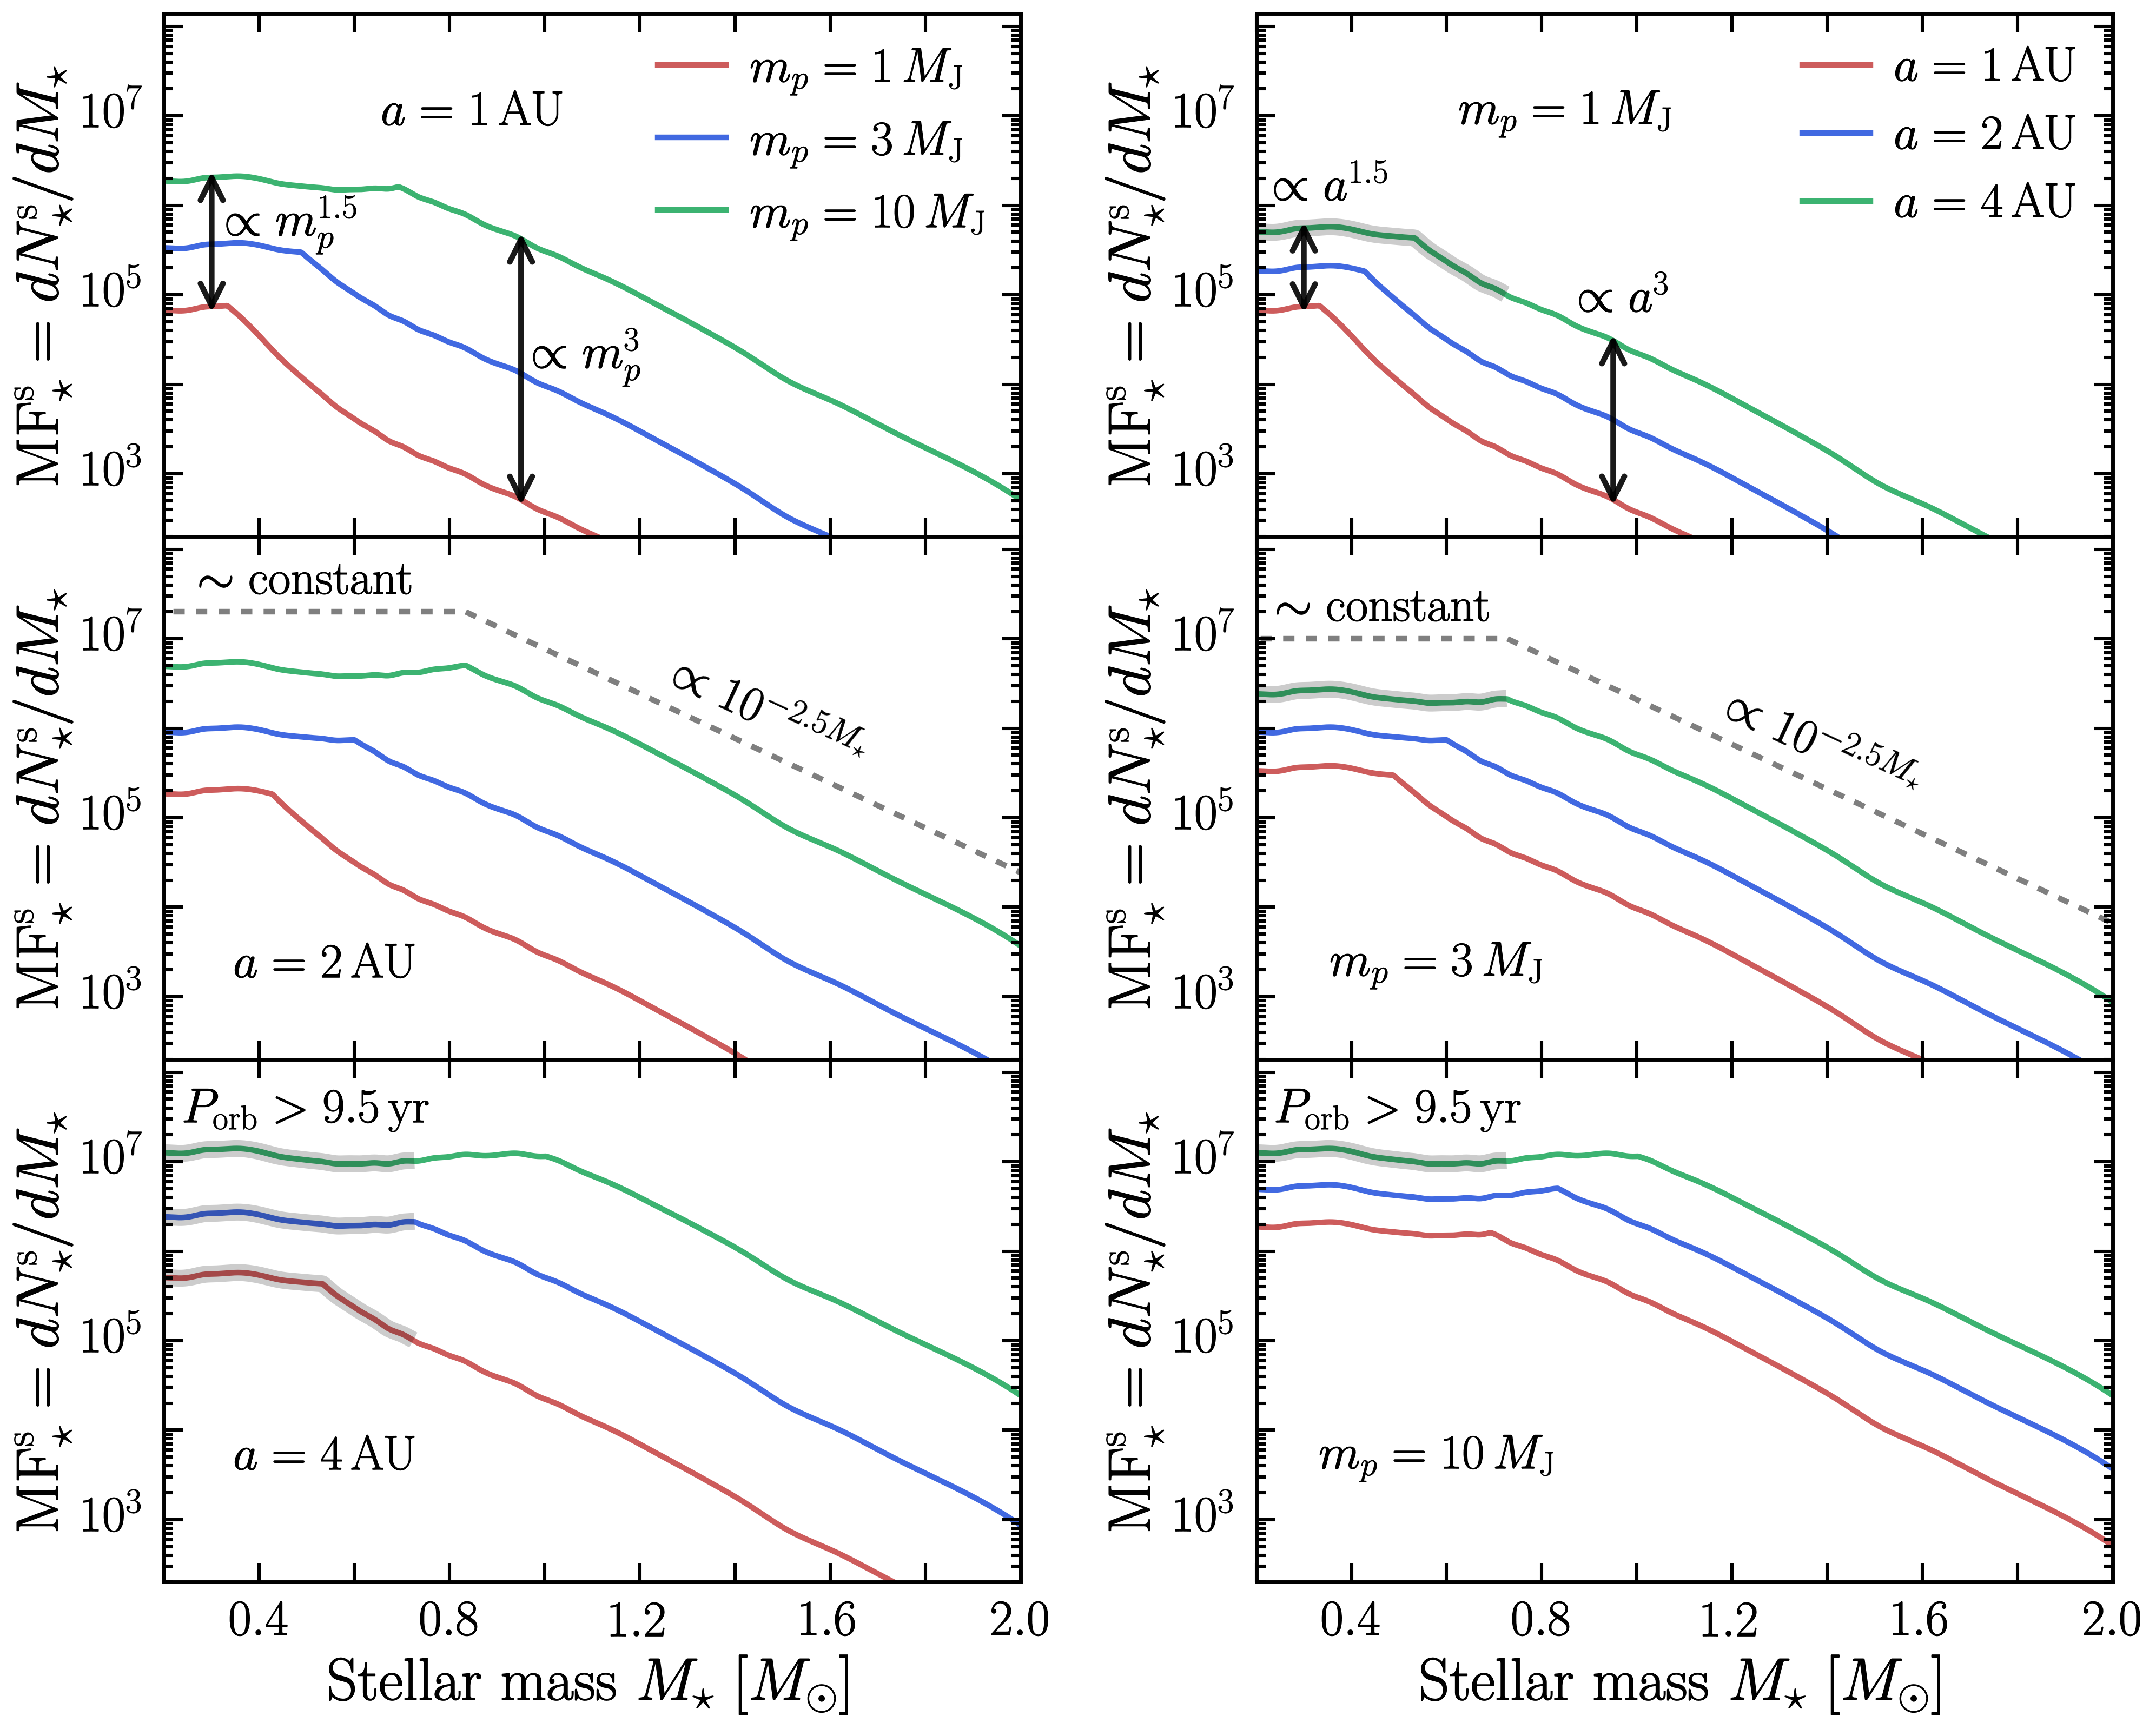

In [8]:
# make plot
fig, axes = plt.subplots(3, 2, figsize=(13.65*1.18, 11.8*1.18*0.93), dpi=250, sharex=True, facecolor='white')
mvals = np.array([1, 3, 10])  # planet masses in Jupiter masses
avals = np.array([1, 2, 4]) # semi-major axes in AU
colors = ['indianred', 'royalblue', 'mediumseagreen']
n_Mvals = 1000
Mvals = np.linspace(0.2, 2.0, n_Mvals)
MGvals = calc_absGmag(Mvals)

# loop through semi-major axis values
for i in range(len(avals)): 
    for j in range(len(mvals)):
        mratiovals = mvals[j] * 0.0009542/Mvals

        # calculate and plot dNsearch_dMstar
        dNsearch_dM = np.zeros(len(Mvals))
        for k in range(len(Mvals)):
            dNsearch_dM[k] = calc_dNsearch_dM(Mvals[k], mvals[j], avals[i], N_sigma=1.0)
        too_long_mask = (avals[i] > 4.48555*Mvals**(1.0/3.0)) # P > 9.5 years threshold
        
        axes[i,0].plot(Mvals, dNsearch_dM, c=colors[j], lw=3, label=rf'$m_p={mvals[j]}\,M_\mathrm{{J}}$')
        
        if np.any(too_long_mask):
            axes[i,0].plot(Mvals[too_long_mask], dNsearch_dM[too_long_mask], 'k-', linewidth=9, alpha=0.2)
          
        axes[i,0].set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
        axes[i,0].set_xticklabels([r'', r'$0.4$', r'', r'$0.8$', r'', r'$1.2$', r'', r'$1.6$', r'', r'$2.0$'])
        
        if j == len(avals)-1:
            axes[i,0].set_xlabel(r'$\mathrm{Stellar~mass}~M_\star~[M_\odot]$', fontsize=32)
        
        axes[i,0].set_ylabel(r'$\mathrm{MF}_\star^\mathrm{s} = dN_\star^\mathrm{s} / dM_\star$', fontsize=32)
        axes[i,0].set_yscale('log')
        axes[i,0].set_yticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
        axes[i,0].set_yticklabels([r'$10^1$', r'', r'$10^3$', r'', r'$10^5$', r'', r'$10^7$', r''])
        axes[i,0].set_xlim(0.2, 2)
        axes[i,0].set_ylim(200, 1.4e8)
        
        if i == 0:
            axes[i,0].legend(loc='best', scatterpoints=1, handletextpad=0.2, borderaxespad=0.3, frameon=False, fontsize=26)

# loop through values of planet mass
for i in range(len(mvals)):
    for j in range(len(avals)):
        mratiovals = mvals[j] * 0.0009542 / Mvals

        # calculate and plot dNsearch_dMstar
        dNsearch_dM = np.zeros(len(Mvals))
        for k in range(len(Mvals)):
            dNsearch_dM[k] = calc_dNsearch_dM(Mvals[k], mvals[i], avals[j], N_sigma=1.0)
        too_long_mask = (avals[j] > 4.48555*Mvals**(1.0/3.0)) # P > 9.5 years threshold

        axes[i,1].plot(Mvals, dNsearch_dM, c=colors[j], lw=3, label=rf'$a={avals[j]}\,\mathrm{{AU}}$')
        
        if np.any(too_long_mask):
            axes[i,1].plot(Mvals[too_long_mask], dNsearch_dM[too_long_mask], 'k-', linewidth=9, alpha=0.2)
            
        axes[i,1].set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
        axes[i,1].set_xticklabels([r'', r'$0.4$', r'', r'$0.8$', r'', r'$1.2$', r'', r'$1.6$', r'', r'$2.0$'])
        
        if j == len(avals)-1:
            axes[i,1].set_xlabel(r'$\mathrm{Stellar~mass}~M_\star~[M_\odot]$', fontsize=32)
            
        axes[i,1].set_ylabel(r'$\mathrm{MF}_\star^\mathrm{s} = dN_\star^\mathrm{s} / dM_\star$', fontsize=32)
        axes[i,1].set_yscale('log')
        axes[i,1].set_yticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
        axes[i,1].set_yticklabels([r'$10^1$', r'', r'$10^3$', r'', r'$10^5$', r'', r'$10^7$', r''])
                
        axes[i,1].set_xlim(0.2, 2)
        axes[i,1].set_ylim(200, 1.4e8)
        
        if i == 0:
            axes[i,1].legend(loc='best', scatterpoints=1, handletextpad=0.2, borderaxespad=0.3, frameon=False, fontsize=26)

# add scaling relations
axes[1,0].plot(np.linspace(0.03, 0.834, 1000), 2.0e7*np.ones(len(np.linspace(0.06, 0.834, 1000))), c='k', lw=3, ls='--', alpha=0.5)
test_grid = np.linspace(0.834, 2.0, 1000)
test_pred = (2.0e7*(10**(2.5*0.834)))*(10**(-2.5*test_grid))
axes[1,0].plot(test_grid, test_pred, c='k', lw=3, ls='--', alpha=0.5)
axes[1,0].text(0.5, 2.38*1.8e7, r'$\sim \mathrm{constant}$', horizontalalignment='center', verticalalignment='center', fontsize=26)
axes[1,0].text(1.47, 2.2*6e5, r'$\propto 10^{-2.5M_\star}$', rotation=-25, horizontalalignment='center', verticalalignment='center', fontsize=26)

axes[1,1].plot(np.linspace(0.02, 0.728, 1000), 1e7*np.ones(len(np.linspace(0.03, 0.728, 1000))), c='k', lw=3, ls='--', alpha=0.5)
test_grid = np.linspace(0.728, 2.0, 1000)
test_pred = (1e7*(10**(2.5*00.728)))*(10**(-2.5*test_grid))
axes[1,1].plot(test_grid, test_pred, c='k', lw=3, ls='--', alpha=0.5)
axes[1,1].text(0.47, 1.95*1.1e7, r'$\sim \mathrm{constant}$', horizontalalignment='center', verticalalignment='center', fontsize=26)
axes[1,1].text(1.39, 2.2*2.6e5, r'$\propto 10^{-2.5M_\star}$', rotation=-25, horizontalalignment='center', verticalalignment='center', fontsize=26)
                
# add semi-a/mp labels
axes[0,0].text(0.85, 1.5*7e6, r'$a = 1\,\mathrm{AU}$', horizontalalignment='center', verticalalignment='center', fontsize=26)
axes[0,1].text(0.85, 1.5*7e6, r'$m_p = 1\,M_\mathrm{J}$', horizontalalignment='center', verticalalignment='center', fontsize=26)

axes[1,0].text(0.54, 1.1*20e2, r'$a = 2\,\mathrm{AU}$', horizontalalignment='center', verticalalignment='center', fontsize=26)
axes[1,1].text(0.58, 1.1*20e2, r'$m_p = 3\,M_\mathrm{J}$', horizontalalignment='center', verticalalignment='center', fontsize=26)

axes[2,0].text(0.54, 1.2*4.0e3, r'$a = 4\,\mathrm{AU}$', horizontalalignment='center', verticalalignment='center', fontsize=26)
axes[2,1].text(0.58, 1.2*4.0e3, r'$m_p = 10\,M_\mathrm{J}$', horizontalalignment='center', verticalalignment='center', fontsize=26)

axes[2,0].text(0.5, 3.7e7, r'$P_\mathrm{orb} > 9.5\,\mathrm{yr}$', horizontalalignment='center', verticalalignment='center', fontsize=26)
axes[2,1].text(0.5, 3.7e7, r'$P_\mathrm{orb} > 9.5\,\mathrm{yr}$', horizontalalignment='center', verticalalignment='center', fontsize=26)
            
# add arrows
x_mid, y_mid = 0.3, 1.9*1.9e5
y_low  = y_mid - (y_mid - y_mid/((3**1.5)*1.09))
y_high = y_mid + (y_mid*((3.3333333**1.5)*1.09) - y_mid)
axes[0,0].annotate('', xy=(x_mid, y_high), xytext=(x_mid, y_low),arrowprops=dict(arrowstyle='<->', lw=3, shrinkA=0, shrinkB=0, mutation_scale=30, alpha=0.9, color='k'), zorder=10)
axes[0,0].text(0.47, 1.85*3.2e5, r'$\propto m_p^{1.5}$', rotation=0, horizontalalignment='center', verticalalignment='center', fontsize=26)

x_mid, y_mid = 0.95, 1.26*10e3
y_low  = y_mid - (y_mid - y_mid/((3**3)*1.05))
y_high = y_mid + (y_mid*((3.3333333**3)*1.05) - y_mid)
axes[0,0].annotate('', xy=(x_mid, y_high), xytext=(x_mid, y_low),arrowprops=dict(arrowstyle='<->', lw=3, shrinkA=0, shrinkB=0, mutation_scale=30, alpha=0.9, color='k'), zorder=10)
axes[0,0].text(1.09, 1.4*1.4e4, r'$\propto m_p^{3}$', rotation=0, horizontalalignment='center', verticalalignment='center', fontsize=26)

x_mid, y_mid = 0.3, 1.84*11e4
y_low  = y_mid - (y_mid - y_mid/((2.0**1.5)*1.14))
y_high = y_mid + (y_mid*((2.0**1.5)*1.14) - y_mid)
axes[0,1].annotate('', xy=(x_mid, y_high), xytext=(x_mid, y_low),arrowprops=dict(arrowstyle='<->', lw=3, shrinkA=0, shrinkB=0, mutation_scale=30, alpha=0.9, color='k'), zorder=10)
axes[0,1].text(0.36, 1.7*9.1e5, r'$\propto a^{1.5}$', rotation=0, horizontalalignment='center', verticalalignment='center', fontsize=26)

x_mid, y_mid = 0.95, 1.21*3.3e3
y_low  = y_mid - (y_mid - y_mid/((2.0**3)*1.12))
y_high = y_mid + (y_mid*((2.0**3)*1.12) - y_mid)
axes[0,1].annotate('', xy=(x_mid, y_high), xytext=(x_mid, y_low),arrowprops=dict(arrowstyle='<->', lw=3, shrinkA=0, shrinkB=0, mutation_scale=30, alpha=0.9, color='k'), zorder=10)
axes[0,1].text(0.975, 1.1*8e4, r'$\propto a^{3}$', rotation=0, horizontalalignment='center', verticalalignment='center', fontsize=26)

plt.tight_layout()
plt.subplots_adjust(hspace=0.0, wspace=0.275)
plt.show()